In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
author = str.lower(input('Welcome! Who are you? ')[0])

dict_root = {
    'k': '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/DL_Project',
    'z': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/',
    'r': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/'
}

if author in dict_root.keys():
  project_root = dict_root[author]
  print('Your root successfully loaded.')
else:
  print('You are not one of us!')
  project_root = '/content'

Welcome! Who are you? Zahra
Your root successfully loaded.


# Packages and Dataset

In [ ]:
! pip -q install --upgrade --no-cache-dir gdown

In [ ]:
import os
import shutil

for fname in ['MSCTD', 'train_ende.zip', 'test.zip']:
  if not fname in os.listdir():
    if not fname in os.listdir(project_root):
      if fname == 'train_ende.zip':
        ! gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
      elif fname == 'test.zip':
        ! gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
      elif fname == 'MSCTD': 
        ! git clone https://github.com/XL2248/MSCTD
    else:
      if fname == 'MSCTD':
        ! git clone https://github.com/XL2248/MSCTD
      else:
        shutil.copy2(os.path.join(project_root, fname), fname)
    if fname in os.listdir():
      if not fname in os.listdir(project_root): 
        if fname == 'MSCTD': 
          shutil.copytree(fname, os.path.join(project_root, fname))
        else: 
          shutil.copy2(fname, os.path.join(project_root, fname))
      print(f'{fname} was added successfully.')
    else:
      print(f'Failed to add {fname}.')

! cp MSCTD/MSCTD_data/ende/english_*.txt .
! cp MSCTD/MSCTD_data/ende/image_index_*.txt .
! cp MSCTD/MSCTD_data/ende/sentiment_*.txt .

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
MSCTD was added successfully.
train_ende.zip was added successfully.
test.zip was added successfully.


In [ ]:
%%bash
for x in *.zip 
do 
  unzip -qq $x
done;

## MSCTDataset

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import ast
import os

class MSCTDataset(Dataset):
    def __init__(self, dirs_dict, include_images=True, include_sentences=True, \
                 include_dialogues=True, include_index=False, pack_dialogues=False,\
                 image_transform=None, sentence_transform=None, sentiment_transform=None, aug_img=None):
        assert include_images or include_sentences, 'you should indicate at least one domain for the dataset.'
        assert isinstance(dirs_dict, dict)
        assert dirs_dict['sentiment']
        self.sentiment_dir = dirs_dict['sentiment']
        self.sentiments = read_txt(self.sentiment_dir, int)
        self.include_images = include_images
        self.include_sentences = include_sentences
        self.include_dialogues = include_dialogues
        self.include_index = include_index
        self.pack_dialogues = pack_dialogues
        self.image_transform = image_transform
        self.sentence_transform = sentence_transform
        self.sentiment_transform = sentiment_transform
        self.aug_img = aug_img

        if include_images:
            assert dirs_dict['image']
            self.image_dir = dirs_dict['image']
        if include_sentences:
            assert dirs_dict['sentence']
            self.sentence_dir = dirs_dict['sentence']
            self.sentences = read_txt(self.sentence_dir)
        if include_dialogues or pack_dialogues:
            assert dirs_dict['dialogue']
            self.dialogue_dir = dirs_dict['dialogue']
            self.dialogues = read_txt(self.dialogue_dir, ast.literal_eval)

    def __len__(self):
        if self.pack_dialogues:
          return len(self.dialogues)
        else:
          return len(self.sentiments)

    def __getoneitem__(self, idx):
        outputs = list()
        if self.include_index:
          outputs.append(idx)
        if self.include_images:
          img_path = os.path.join(self.image_dir, str(idx) + '.jpg')
          image = Image.open(img_path) # read_image(img_path)
          if self.image_transform:
            image = self.image_transform(image)
          outputs.append(image)

        if self.include_sentences:
          sentence = self.sentences[idx]
          if self.sentence_transform:
            sentence = self.sentence_transform(sentence)
          outputs.append(sentence)

        if self.include_dialogues:
          for dialogue in self.dialogues:
            if idx in dialogue:
              break
          outputs.append(dialogue)
        
        sentiment = self.sentiments[idx]
        if self.sentiment_transform:
          sentiment = self.sentiment_transform(sentiment)
        outputs.append(sentiment)
        return outputs

    def __getitem__(self, idx):
      if self.pack_dialogues:
        indices = self.dialogues[idx]
        outputs = [self.__getoneitem__(i) for i in indices]
        final_output = [[outputs[i][j] for i in range(len(outputs))] for j in range(len(outputs[0]))]
        return final_output
      else:
        return self.__getoneitem__(idx)

      
def read_txt(path, line_transform=None):
    ls = list()
    with open(path, 'r') as f:
        for line in f:
            if line_transform:
              line = line_transform(line)
            else:
              if line[-1:] == '\n':
                line = line[:-1]
            ls.append(line)
    return ls

# Part 1: Analysing faces of MSCTD

## Implementing method

### 1. Face extraction model

In [ ]:
! pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as T
from torchvision.transforms import Compose
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from IPython import display
from tqdm import tqdm
import pickle
import numpy as np
from collections import defaultdict
from copy import deepcopy
import glob
import random
import imutils
from PIL import ImageEnhance
import cv2

train_dirs = {'image':'/content/train_ende', 'sentence':'/content/english_train.txt', \
              'dialogue':'/content/image_index_train.txt', 'sentiment':'/content/sentiment_train.txt'}
test_dirs = {'image':'/content/test', 'sentence':'/content/english_test.txt', \
              'dialogue':'/content/image_index_test.txt', 'sentiment':'/content/sentiment_test.txt'}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

In [ ]:
class MTCNNWrapper(nn.Module):
  def __init__(self, model, include_boxes=False, include_scores=False, \
               face_transform=None):
    super().__init__()
    self.model = model
    self.include_boxes = include_boxes
    self.include_scores = include_scores
    self.face_transform = face_transform
    self.tensor2pil = T.ToPILImage()

  def forward(self, input):
    if isinstance(input, torch.Tensor):
      input = self.tensor2pil(input)
    assert isinstance(input, Image.Image)

    boxes, face_logits = self.model.detect(frame)
    output_faces = list()
    boxes = list() if boxes is None else boxes
    face_logits = list() if boxes is None else face_logits

    for box in boxes:
      face = input.copy().crop(box.tolist())
      if self.face_transform:
        face = self.face_transform(face)
      output_faces.append(face)
    
    outputs = [output_faces]
    if self.include_boxes: outputs.append(boxes)
    if self.include_scores: outputs.append(face_logits)
    outputs = outputs if len(outputs) > 1 else outputs[0]
    return outputs


In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)
mtcnn_wrapped = MTCNNWrapper(mtcnn)

train_data = MSCTDataset(train_dirs, pack_dialogues=False)
test_data = MSCTDataset(test_dirs, pack_dialogues=False)

Number of detected faces: 2


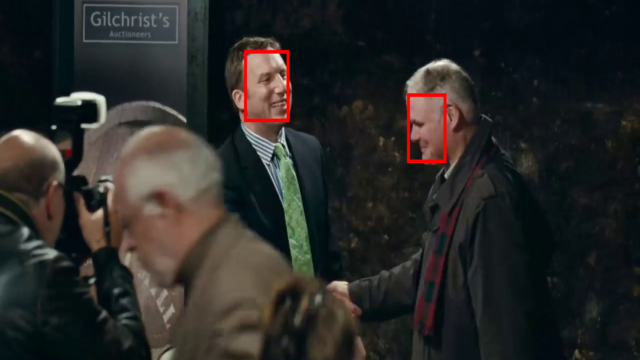


Output of the wrapped model:


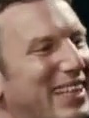

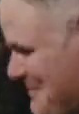

In [ ]:
frame, sentence, dialogue, sentiment = train_data[4321]
boxes, face_logits = mtcnn.detect(frame)
frame_draw = frame.copy()
if boxes is not None:
  draw = ImageDraw.Draw(frame_draw)
  print(f"Number of detected faces: {len(face_logits)}")
  for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
else:
  print(f"Number of detected faces: 0")

display.display(frame_draw.resize((640, 360), Image.BILINEAR), display_id=True)

detected_faces = mtcnn_wrapped(frame)
print('\nOutput of the wrapped model:')
for face in detected_faces:
  display.display(face, display_id=True)


### 2. Face classification CNN model

In [ ]:
facedataset_root = os.path.join(project_root, 'Face Dataset')
facedataset_labels_root = {(phase, s): os.path.join(facedataset_root, phase, str(s)) for s in range(3) for phase in ['test', 'train']}
for root in facedataset_labels_root.values(): os.makedirs(root, exist_ok=True)

In [ ]:
facedataset_resized_root = os.path.join(project_root, 'Face Dataset - resized')
facedataset_resized_labels_root = {(phase, s): os.path.join(facedataset_resized_root, phase, str(s)) for s in range(3) for phase in ['test', 'train']}
for root in facedataset_resized_labels_root.values(): os.makedirs(root, exist_ok=True)
resnet_fc_training_root = os.path.join(project_root, 'training checkpoints 2', 'InceptionResnetV1 finetuning fc')
os.makedirs(resnet_fc_training_root, exist_ok=True)

#### DO NOT RUN: Crearting a face dataset
**Only run this cell if the dataset has not been created.**

In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)
mtcnn_wrapped = MTCNNWrapper(mtcnn, include_boxes=True, include_scores=True)

datasets = dict()
datasets['train'] = MSCTDataset(train_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False)
datasets['test'] = MSCTDataset(test_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False)

In [ ]:
for phase in ['train', 'test']:
  boxes, scores, frame_dims = list(), list(), list()
  for frame, sentiment in tqdm(datasets[phase]):
    frame_dims.append(frame.size)
    fs, bs, ss = mtcnn_wrapped(frame)
    boxes.append(bs)
    scores.append(ss)
    if len(fs) == 0:
      if len(boxes) == len(datasets[phase]): 
        break
      continue
    for i, face in enumerate(fs):
      fp = os.path.join(facedataset_labels_root[(phase, sentiment)], f'{len(boxes) - 1}_{i}.jpg')
      face.save(fp)
    if len(boxes) == len(datasets[phase]): 
      break
  with open(os.path.join(facedataset_root, f"boxes_{phase}.pkl"), "wb") as f:
    pickle.dump(boxes, f)
  with open(os.path.join(facedataset_resized_root, f"boxes_{phase}.pkl"), "wb") as f:
    pickle.dump(boxes, f)
  with open(os.path.join(facedataset_root, f"scores_{phase}.pkl"), "wb") as f:
    pickle.dump(scores, f)
  with open(os.path.join(facedataset_resized_root, f"scores_{phase}.pkl"), "wb") as f:
    pickle.dump(scores, f)
  with open(os.path.join(facedataset_root, f"frame_dims_{phase}.pkl"), "wb") as f:
    pickle.dump(frame_dims, f)
  with open(os.path.join(facedataset_resized_root, f"frame_dims_{phase}.pkl"), "wb") as f:
    pickle.dump(frame_dims, f)


100%|█████████▉| 5066/5067 [06:50<00:00, 12.34it/s]


In [ ]:
for root1, root2 in zip(facedataset_labels_root.values(), facedataset_resized_labels_root.values()):
  pbar = tqdm(os.listdir(root1))
  for fn in pbar:
    fp1 = os.path.join(root1, fn)
    fp2 = os.path.join(root2, fn)
    img = Image.open(fp1)
    img = img.resize((256, 256))
    img.save(fp2)
    pbar.set_description(f'resizing {root1}')

resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/test/0: 100%|██████████| 1812/1812 [00:26<00:00, 67.56it/s]
resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/train/0: 100%|██████████| 10853/10853 [02:41<00:00, 67.08it/s]
resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/test/1: 100%|██████████| 3191/3191 [01:20<00:00, 39.82it/s]
resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/train/1: 100%|██████████| 11599/11599 [05:32<00:00, 34.91it/s]
resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/test/2: 100%|██████████| 2750/2750 [01:12<00:00, 37.83it/s]
resizing /content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/Face Dataset/train/2: 100%|██████████| 8741/8741 [04:06<00:00, 35

#### Loading face dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

batch_size = 64
transform = transforms.Compose([
#   transforms.CenterCrop(224),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    fixed_image_standardization
])
face_datasets = {phase: ImageFolder(root=os.path.join(facedataset_resized_root, phase), transform=transform) for phase in ['train', 'test']}
face_dataloaders = {phase: DataLoader(face_datasets[phase], batch_size=batch_size, num_workers=2, shuffle=True) for phase in ['train', 'test']}

#### DO NOT RUN: Finetuning InceptionResnetV1
Note: You don't need to run this cell. The best model will be loaded in the next section. 

The highest test accuracy for the trained model is 41.12%

In [ ]:
def run_epoch(model, optimizer, criterion, dataloader, sched=None, phases=['train', 'test']):
    model.to(device)
    accs = {phase: 0 for phase in phases}
    losses = {phase: 0 for phase in phases}
    for phase in phases:
        if phase == 'train':
          model.train()
        else:
          model.eval()
          
        pbar = tqdm(dataloader[phase], leave=phase=='test')
        n_data, correct_all, loss_all = 0, 0, 0

        for X, y in pbar:
            n_data += X.shape[0]
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if sched:
                  sched.step()

            pred = pred.argmax(axis=1)
            correct_all += (pred == y).sum().item()
            loss_all += loss.item()

            accs[phase] = correct_all / n_data
            losses[phase] = loss_all / n_data
            desc_str = ''
            for ph in phases: 
                desc_str += ' ' * 5 + f'{ph} loss: {losses[ph]:.6f}   {ph} accuracy: {accs[ph]:.4f}' 
            pbar.set_description(f'Epoch {epoch:3.0f}: {desc_str}')
    return accs, losses

def plot_history(losses, accs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    legend = list()
    for phase in losses.keys():
      plt.plot(range(1, len(losses[phase]) + 1), losses[phase])
      legend.append(f'{phase} loss')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')

    plt.subplot(2, 1, 2)
    legend = list()
    for phase in accs.keys():
      plt.plot(range(1, len(accs[phase]) + 1), accs[phase])
      legend.append(f'{phase} accuracy')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
inception_resnet = InceptionResnetV1(pretrained='vggface2', classify=True)

params = inception_resnet.parameters()
for param in params: 
  param.requires_grad = False

inception_resnet.logits = nn.Linear(in_features=512, out_features=3, bias=True)
inception_resnet = inception_resnet.to(device)
resnet_accs, resnet_losses = defaultdict(list), defaultdict(list)

  0%|          | 0.00/107M [00:00<?, ?B/s]

Epoch   1:      train loss: 0.018642   train accuracy: 0.3379     test loss: 0.017633   test accuracy: 0.3351: 100%|██████████| 122/122 [00:25<00:00,  4.73it/s]
Epoch   2:      train loss: 0.017279   train accuracy: 0.3598     test loss: 0.017338   test accuracy: 0.3455: 100%|██████████| 122/122 [00:25<00:00,  4.75it/s]
Epoch   3:      train loss: 0.017095   train accuracy: 0.3749     test loss: 0.017321   test accuracy: 0.3492: 100%|██████████| 122/122 [00:29<00:00,  4.12it/s]
Epoch   4:      train loss: 0.017067   train accuracy: 0.3767     test loss: 0.017296   test accuracy: 0.3484: 100%|██████████| 122/122 [00:27<00:00,  4.40it/s]
Epoch   5:      train loss: 0.017059   train accuracy: 0.3780     test loss: 0.017328   test accuracy: 0.3436: 100%|██████████| 122/122 [00:25<00:00,  4.75it/s]


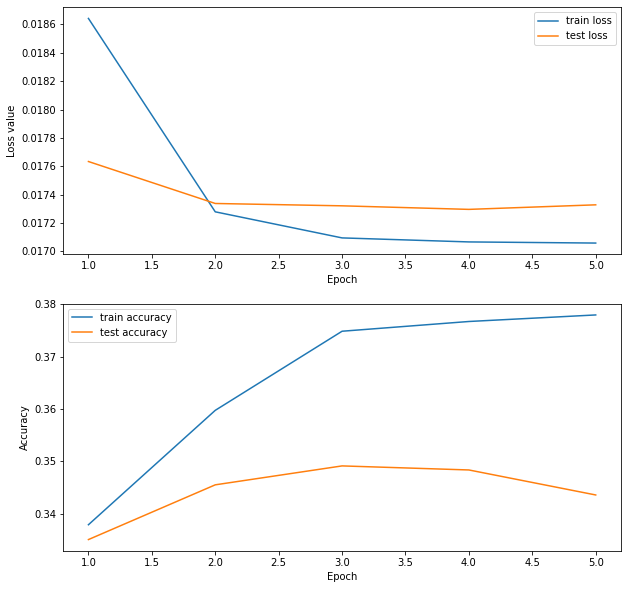

In [ ]:
max_lr = 0.0001
weight_decay = 1e-4
n_epochs = 5

fc_params = inception_resnet.logits.parameters()
optimizer = optim.Adam(fc_params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, 
                                      steps_per_epoch=len(face_dataloaders['train']))
criterion = nn.CrossEntropyLoss()

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(resnet_accs['train']) + 1
  accs, losses = run_epoch(inception_resnet, optimizer, criterion, face_dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    resnet_accs[phase].append(accs[phase])
    resnet_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(resnet_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(resnet_losses, f)

  if resnet_accs['test'][-1] == max(resnet_accs['test']): 
    best_inception_resnet = deepcopy(inception_resnet)
    
torch.save(inception_resnet.logits, os.path.join(resnet_fc_training_root, f"InceptionResnetV1_fc_epoch{len(resnet_accs['test'])}.pt"))
torch.save(best_inception_resnet.logits, os.path.join(resnet_fc_training_root, 
                                               f"best_InceptionResnetV1_fc_epoch{1 + np.argmax(resnet_accs['test'])}_acc{max(resnet_accs['test'])}.pt"))
plot_history(resnet_losses, resnet_accs)

In [ ]:
params = inception_resnet.parameters()
for param in params: 
  param.requires_grad = True
  
max_lr = 0.00005
params = inception_resnet.parameters()
optimizer = optim.SGD(params, lr=max_lr, momentum=0.9) # optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = None # optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, steps_per_epoch=len(face_dataloaders['train']))
criterion = nn.CrossEntropyLoss()

Epoch  16:      train loss: 0.016929   train accuracy: 0.3962     test loss: 0.017076   test accuracy: 0.3792: 100%|██████████| 122/122 [00:32<00:00,  3.70it/s]


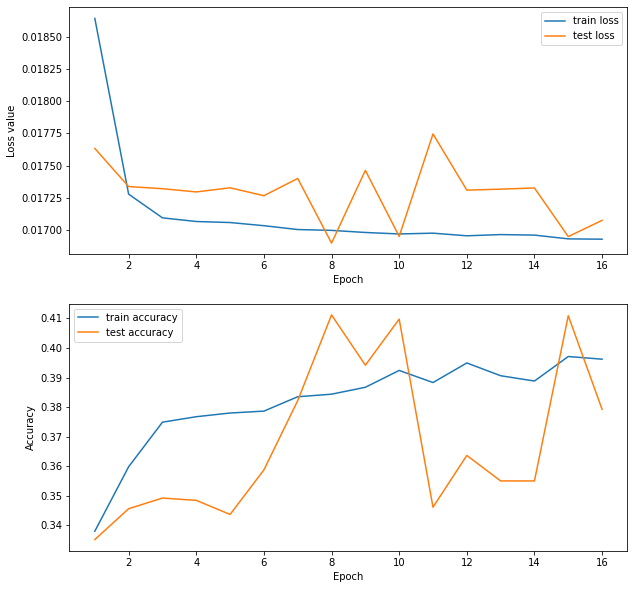


Highest test accuracy is 41.12%


In [ ]:
n_epochs = 11

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(resnet_accs['train']) + 1
  accs, losses = run_epoch(inception_resnet, optimizer, criterion, face_dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    resnet_accs[phase].append(accs[phase])
    resnet_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(resnet_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(resnet_losses, f)

  if resnet_accs['test'][-1] == max(resnet_accs['test']): 
    best_inception_resnet2 = deepcopy(inception_resnet)
    
torch.save(inception_resnet, os.path.join(resnet_fc_training_root, f"InceptionResnetV1_epoch{len(resnet_accs['test'])}.pt"))
torch.save(best_inception_resnet2, os.path.join(resnet_fc_training_root, 
                                               f"best_InceptionResnetV1_epoch{1 + np.argmax(resnet_accs['test'])}_acc{max(resnet_accs['test']):.4f}.pt"))
plot_history(resnet_losses, resnet_accs)
print(f"\nHighest test accuracy is {100 * max(resnet_accs['test']):.2f}%")

### 3. Scene classification model

#### DO NOT RUN: Training label weight generator

In [ ]:
from collections import defaultdict

class FaceDataset(Dataset):
    def __init__(self, facedataset_resized_root, phase, image_transform=transforms.ToTensor(), pack=False, label_transform=None):
        self.pack = pack
        self.facedataset_resized_root = facedataset_resized_root
        self.phase = phase
        self.filenames = dict()
        for i in range(3):
          for fn in os.listdir(os.path.join(facedataset_resized_root, phase, str(i))):
            self.filenames[fn] = i
        
        fp = os.path.join(facedataset_resized_root, 'scores_' + phase + '.pkl')
        with open(fp, 'rb') as f:
          scores = pickle.load(f)

        fp = os.path.join(facedataset_resized_root, 'frame_dims_' + phase + '.pkl')
        with open(fp, 'rb') as f:
          self.frame_dims = np.array(pickle.load(f))

        fp = os.path.join(facedataset_resized_root, 'boxes_' + phase + '.pkl')
        with open(fp, 'rb') as f:
          boxes = pickle.load(f)
        
        self.filename_vs_row = dict()
        self.boxes = list()
        self.frame_dims_all = list()
        self.frame_vs_filenames = defaultdict(list)
        for i_frame, bs in enumerate(boxes):
          for i_face, b in enumerate(bs):
            self.filename_vs_row[f'{i_frame}_{i_face}.jpg'] = len(self.boxes)
            self.boxes.append(torch.tensor(b.ravel()))
            self.frame_dims_all.append(torch.tensor(self.frame_dims[i_frame]))
            self.frame_vs_filenames[i_frame].append(f'{i_frame}_{i_face}.jpg')
        self.image_transform = image_transform
        self.scores = list()
        for ss in scores:
          for s in ss:
            if s is None: continue
            self.scores.append(torch.tensor(s))
        self.fn_keys = list(self.filenames.keys())
        self.fn_vals = list(self.filenames.values())
        
    def __getoneitem__(self, fn, sentiment):
        if sentiment is None:
          sentiment = self.filenames[fn]
        img_path = os.path.join(self.facedataset_resized_root, self.phase, str(sentiment), fn)
        image = Image.open(img_path) # read_image(img_path)
        if self.image_transform:
          image = self.image_transform(image)
        row = self.filename_vs_row[fn]
        box = self.boxes[row]
        score = self.scores[row]
        frame_dims = self.frame_dims_all[row]
        return (image, box, score, frame_dims), sentiment

    def __getitem__(self, index):
        if not self.pack:
          fn = self.fn_keys[index]
          s = self.fn_vals[index]
          return self.__getoneitem__(fn, s)
        i_frame = list(self.frame_vs_filenames.keys())[index]
        n = len(self.frame_vs_filenames[i_frame])
        images, boxes, scores, frame_dims_ls, sentiments = list(), list(), list(), list(), list()
        fns = self.frame_vs_filenames[i_frame] if self.pack else [list(self.filenames.keys())[index]]
        for fn in fns:
          (image, box, score, frame_dims), sentiment = self.__getoneitem__(fn)
          images.append(image)
          boxes.append(box)
          scores.append(score)
          frame_dims_ls.append(frame_dims)
          sentiments.append(sentiment)
        images = torch.stack(images)
        boxes = torch.stack(boxes)
        scores = torch.stack(scores)
        frame_dims_ls = torch.stack(frame_dims_ls)
        sentiments = torch.tensor(sentiments)
        return (images, boxes, scores, frame_dims_ls), sentiments

    def __len__(self):
        if self.pack: return len(self.frame_vs_filenames.keys())
        else: return len(self.filenames.keys())


In [ ]:
shutil.copytree(facedataset_resized_root, 'Face Dataset - resized')

'Face Dataset - resized'

In [ ]:
batch_size = 64

packedface_datasets = {phase: FaceDataset('Face Dataset - resized', phase, transform) for phase in ['train', 'test']}
packedface_dataloaders = {phase: DataLoader(packedface_datasets[phase], batch_size=batch_size, num_workers=2, shuffle=True) for phase in ['train', 'test']}

face_classifier = torch.load(os.path.join(resnet_fc_training_root, f"best_InceptionResnetV1_epoch{8}_acc{0.4112}.pt"))

In [ ]:
import time

def get_dims_from_box(box, frame_shape):
    return np.abs(box[0] - box[2]) / frame_shape[0], np.abs(box[1] - box[3]) / frame_shape[1]

def get_area_from_box(box, frame_shape):
    dx, dy = get_dims_from_box(box, frame_shape)
    return dx * dy

def get_center_from_box(box):
    return np.abs(box[0] + box[2]), np.abs(box[1] + box[3])

def get_dist_center_from_box(box, frame_shape): 
    x, y = np.abs(box[0] + box[2]) / 2, np.abs(box[1] + box[3]) / 2
    dx, dy = (frame_shape[0] - x) / frame_shape[0], (frame_shape[1] - y) / frame_shape[1]
    return np.sqrt(dx**2 + dy**2)

def get_box_feature(box, frame_shape):
    box = box.cpu().numpy().ravel()
    frame_shape = frame_shape.cpu().numpy().ravel()
    area = get_area_from_box(box, frame_shape)
    dist = get_dist_center_from_box(box, frame_shape)
    dx, dy = get_dims_from_box(box, frame_shape)
    return torch.tensor([area, dist, dx, dy]).to(device)

def get_label_features(face_data, face_classifier):
    faces, boxes, scores, frame_shape = face_data
    face_features = torch.zeros(faces.shape[0], 4).to(device)
    face_predictions = face_classifier(faces).detach()
    for i, box in enumerate(boxes):
      feature = get_box_feature(box, frame_shape).to(device)
      face_features[i] = feature
    scores = scores.reshape(-1, 1)
    # areas_sum = face_features[:, 0].sum()
    # face_features[:, 0] /= areas_sum
    label_features = torch.cat((face_features, scores, face_predictions), 1) # torch.cat((face_features, scores), 1) # 
    return face_predictions.detach(), label_features.detach()

In [ ]:
def run_epoch2(label_weight_generator, optimizer, criterion, dataloader, face_classifier=face_classifier, sched=None, phases=['train', 'test']):
    label_weight_generator.to(device)
    accs = {phase: 0 for phase in phases}
    losses = {phase: 0 for phase in phases}
    for phase in phases:
        if phase == 'train':
          label_weight_generator.train()
        else:
          label_weight_generator.eval()
          
        pbar = tqdm(dataloader[phase], leave=phase=='test')
        n_data, correct_all, loss_all = 0, 0, 0

        start = time.time()
        for (images, boxes, scores, frame_dims), y in pbar:
            end = time.time()
            # print(f'time: {end-start}')
            images = images.squeeze(0).to(device)
            boxes = boxes.squeeze(0)
            scores = scores.squeeze(0).to(device)
            frame_dims = frame_dims.squeeze(0)
            y = y.squeeze(0).to(device)

            n_data += images.shape[0]

            face_predictions, label_features = get_label_features((images, boxes, scores, frame_dims), face_classifier)

            # print(f'face_predictions {face_predictions.shape}, label_features {label_features.shape}')
            label_weights = label_weight_generator(label_features)
            # print(f'label_weights.shape {label_weights.shape}')
            pred = face_predictions * label_weights

            # print(f'pred {pred.shape}, y {y.shape}, images.shape[0] {images.shape[0]}')
            loss = criterion(pred, y)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if sched:
                  sched.step()

            pred = pred.argmax(axis=1)
            correct_all += (pred == y).sum().item()
            loss_all += loss.item()

            accs[phase] = correct_all / n_data
            losses[phase] = loss_all / n_data
            desc_str = ''
            for ph in phases: 
                desc_str += ' ' * 5 + f'{ph} loss: {losses[ph]:.6f}   {ph} accuracy: {accs[ph]:.4f}' 
            pbar.set_description(f'Epoch {epoch:3.0f}: {desc_str}')
            start = time.time()
    return accs, losses

def plot_history(losses, accs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    legend = list()
    for phase in losses.keys():
      plt.plot(range(1, len(losses[phase]) + 1), losses[phase])
      legend.append(f'{phase} loss')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')

    plt.subplot(2, 1, 2)
    legend = list()
    for phase in accs.keys():
      plt.plot(range(1, len(accs[phase]) + 1), accs[phase])
      legend.append(f'{phase} accuracy')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
class MLPNetwork(nn.Module):
  def __init__(self):
    super(MLPNetwork, self).__init__()
    self.fc1 = nn.Linear(8, 512)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(512, 256)
    self.dropout2 = nn.Dropout(0.2)
    self.fc3 = nn.Linear(256, 128)
    self.dropout3 = nn.Dropout(0.2)
    self.fc4 = nn.Linear(128, 32)
    self.dropout4 = nn.Dropout(0.2)
    self.fc5 = nn.Linear(32, 8)
    self.dropout5 = nn.Dropout(0.2)
    self.fc6 = nn.Linear(8, 1)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.dropout3(x)
    x = F.relu(self.fc4(x))
    x = self.dropout4(x)
    x = F.relu(self.fc5(x))
    x = self.dropout5(x)
    x = self.fc6(x)
    x = torch.sigmoid(x)
    return x

In [ ]:
label_weight_generator = MLPNetwork().to(device)
generator_accs, generator_losses = defaultdict(list), defaultdict(list)
label_weight_generator

MLPNetwork(
  (fc1): Linear(in_features=8, out_features=512, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=32, out_features=8, bias=True)
  (dropout5): Dropout(p=0.2, inplace=False)
  (fc6): Linear(in_features=8, out_features=1, bias=True)
)

Epoch   1:      train loss: 0.017189   train accuracy: 0.3719     test loss: 0.017277   test accuracy: 0.4111: 100%|██████████| 122/122 [00:57<00:00,  2.11it/s]
Epoch   2:      train loss: 0.017188   train accuracy: 0.3719     test loss: 0.017288   test accuracy: 0.4116: 100%|██████████| 122/122 [00:54<00:00,  2.24it/s]
Epoch   3:      train loss: 0.017184   train accuracy: 0.3720     test loss: 0.017259   test accuracy: 0.4108: 100%|██████████| 122/122 [00:50<00:00,  2.42it/s]
Epoch   4:      train loss: 0.017185   train accuracy: 0.3718     test loss: 0.017183   test accuracy: 0.4109: 100%|██████████| 122/122 [00:53<00:00,  2.26it/s]
Epoch   5:      train loss: 0.017180   train accuracy: 0.3718     test loss: 0.017184   test accuracy: 0.4112: 100%|██████████| 122/122 [00:50<00:00,  2.40it/s]
Epoch   6:      train loss: 0.017181   train accuracy: 0.3719     test loss: 0.017175   test accuracy: 0.4116: 100%|██████████| 122/122 [00:54<00:00,  2.22it/s]
Epoch   7:      train loss: 0.0171

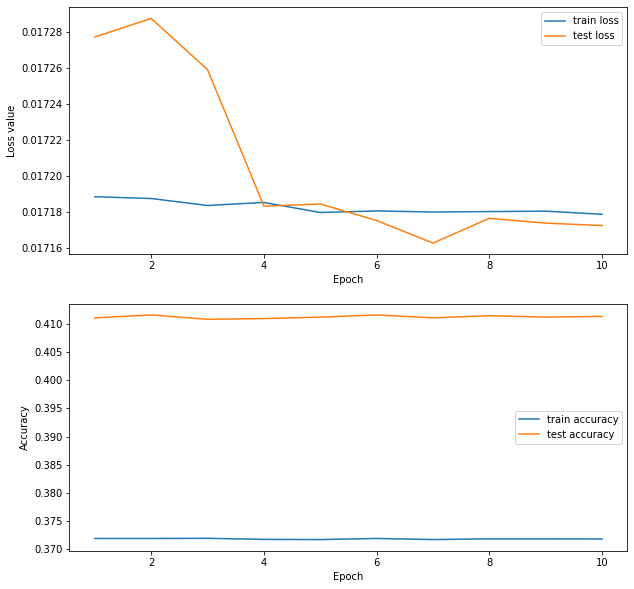

In [ ]:
max_lr = 0.01
weight_decay = 1e-4
n_epochs = 10

params = label_weight_generator.parameters()
optimizer = optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, 
                                      steps_per_epoch=len(packedface_dataloaders['train']))
criterion = nn.CrossEntropyLoss()
torch.autograd.set_detect_anomaly(True)

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(generator_accs['train']) + 1
  accs, losses = run_epoch2(label_weight_generator, optimizer, criterion, packedface_dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    generator_accs[phase].append(accs[phase])
    generator_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(generator_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(generator_losses, f)

  if generator_accs['test'][-1] == max(generator_accs['test']): 
    best_label_weight_generator = deepcopy(label_weight_generator)
    
torch.save(label_weight_generator, os.path.join(resnet_fc_training_root, f"label_weight_generator_epoch{len(generator_accs['test'])}.pt"))
torch.save(best_label_weight_generator, os.path.join(resnet_fc_training_root, f"best_label_weight_generator_epoch{1 + np.argmax(generator_accs['test'])}_acc{max(generator_accs['test'])}.pt"))
plot_history(generator_losses, generator_accs)

### Loading label weight generator

In [ ]:
import time

def get_dims_from_box(box, frame_shape):
    return np.abs(box[0] - box[2]) / frame_shape[0], np.abs(box[1] - box[3]) / frame_shape[1]

def get_area_from_box(box, frame_shape):
    dx, dy = get_dims_from_box(box, frame_shape)
    return dx * dy

def get_center_from_box(box):
    return np.abs(box[0] + box[2]), np.abs(box[1] + box[3])

def get_dist_center_from_box(box, frame_shape): 
    x, y = np.abs(box[0] + box[2]) / 2, np.abs(box[1] + box[3]) / 2
    dx, dy = (frame_shape[0] - x) / frame_shape[0], (frame_shape[1] - y) / frame_shape[1]
    return np.sqrt(dx**2 + dy**2)

def get_box_feature(box, frame_shape):
    box = box.cpu().numpy().ravel()
    frame_shape = frame_shape.cpu().numpy().ravel()
    area = get_area_from_box(box, frame_shape)
    dist = get_dist_center_from_box(box, frame_shape)
    dx, dy = get_dims_from_box(box, frame_shape)
    return torch.tensor([area, dist, dx, dy]).to(device)


In [ ]:
face_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        # transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        fixed_image_standardization
    ])

from statistics import mode
import random

class SceneClassifier(nn.Module):
  def __init__(self, face_classifier, label_weight_generator=None, face_transform=face_transform):
    super().__init__()
    mtcnn = MTCNN(keep_all=True, device=device)
    self.mtcnn_wrapped = MTCNNWrapper(mtcnn, include_boxes=True, include_scores=True,\
                                      face_transform=face_transform)
    self.face_classifier = face_classifier.to(device)
    # self.label_weight_generator = label_weight_generator
    
  def forward(self, scene):
    self.face_classifier.eval()
    faces, boxes, scores = self.mtcnn_wrapped(scene)
    if len(faces) == 0:
      train_dist = torch.tensor([6922, 7835, 5483])
      #return (train_dist / train_dist.sum()).to(device)
      return train_dist.argmax()
    # preds = list()
    preds = np.zeros((3,))
    for face, box, score in zip(faces, boxes, scores):
      box = torch.tensor(box.ravel())
      score = torch.tensor(score)
      frame_dims = torch.tensor(scene.size)
      face = face.to(device).unsqueeze(0)
      face_predictions = self.face_classifier(face)
      p = F.softmax(face_predictions, 1)
      logp = torch.log2(p)
      entropy = torch.sum(-p * logp).item()
      # print(entropy)
      # preds.append(face_predictions.argmax().item())
      pred = face_predictions.argmax().item()
      # print('en',1 / entropy)
      preds[pred] += (1 / entropy)
      # face_predictions, label_features = self.get_label_features(self, (face, box, score, frame_dims))
      # label_weights = label_weight_generator(label_features)
      # pred = face_predictions * label_weights if pred is None else pred + face_predictions * label_weights
    # random.shuffle(preds)
    # print(preds)
    return preds.argmax()

  def get_label_features(self, face_data):
    faces, boxes, scores, frame_shape = face_data
    face_features = torch.zeros(len(faces), 5).to(device)
    face_predictions = torch.zeros(len(faces), 3).to(device)
    feature = get_box_feature(box, frame_shape).to(device)
    face_features[i, :-1] = feature
    face_features[i, -1] = torch.tensor(scores).to(device)
    face = face.to(device)
    face_predictions[i] = self.face_classifier(face)
    areas_sum = face_features[:, 0].sum()
    face_features[:, 0] /= areas_sum
    label_features = torch.cat((face_features, face_predictions), 1)
    return face_predictions, label_features


In [ ]:
face_classifier = torch.load(os.path.join(resnet_fc_training_root, f"best_InceptionResnetV1_epoch{8}_acc{0.4112}.pt"))
# label_weight_generator = torch.load(os.path.join(resnet_fc_training_root, f"label_weight_generator_epoch10.pt"))
scene_classifier = SceneClassifier(face_classifier)

sentiment: 1, predicted: 1
God, the things we worry about.


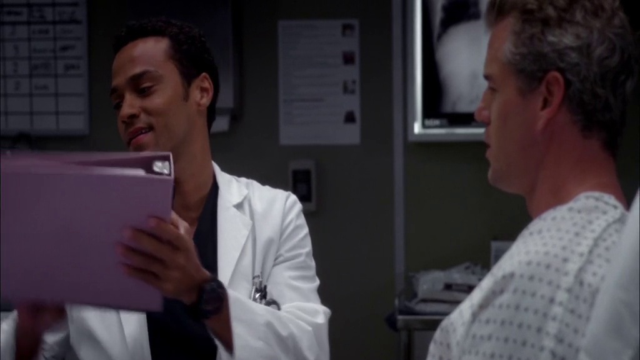

In [ ]:
frame, sentence, dialogue, sentiment = train_data[200]
pred = scene_classifier(frame)

print(f'sentiment: {sentiment}, predicted: {pred}\n{sentence}')
display.display(frame.resize((640, 360), Image.BILINEAR), display_id=False)

In [ ]:
dataset = MSCTDataset(test_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False)

corrects = list()
pbar = tqdm(dataset)
for frame, sentiment in pbar:
  pred = scene_classifier(frame)
  corrects.append(1. * (sentiment == pred))
  # print(pred)
  pbar.set_description(f'accuracy: {np.mean(corrects) * 100 :.2f}%')
  if len(corrects) == len(dataset): 
    break

print(f'Final accuracy: {np.mean(corrects) * 100 :.2f}%')

accuracy: 42.69%: 100%|█████████▉| 5066/5067 [11:42<00:00,  7.21it/s]

Final accuracy: 42.69%


## Data Augmentation

In [ ]:
from PIL import Image, ImageDraw

def flip(img):
    r = random.choice([0, 10, -10])
    rotation = transforms.RandomRotation((r,r))
    # fv = transforms.RandomVerticalFlip(0.5)
    fh = transforms.RandomHorizontalFlip(0.5)
    img = rotation(img)
    img = fh(img)
    return img

def gaussian_noise(img, var=0.7):
    img = np.array(img)
    dims = np.shape(img)
    active = random.choice([0,1])
    if active == 1:
      noise = np.random.normal(0,var,size=dims).astype("uint8")
      img = img + noise
    return (img)

def jitter(img):
    b = random.choice([0.75, 0.5, 1]) # ,2,4
    c = random.choice([0.75, 0.5, 1]) # ,2,4
    s = random.choice([0.75, 0.5, 1]) # ,2,4
    h = random.choice([0.1, 0.2, 0.3, 0.4])
    transform = transforms.ColorJitter(brightness=b, contrast=c, saturation=s, hue=h)
    img = transform(img)
    return(img)

def salt_pepper_noise(img):
    active = random.choice([0,1])
    prob = random.choice([0.1,0.2,0.3])
    if active == 1:
      height,width,channels = np.shape(img)
      
      for i in range(height):
          for j in range(width):
              if random.random()<prob:
                  if random.random() < 0.5:
                      img[i][j] = np.array([255,255,255]) 
                  else:
                      img[i][j] = np.array([0,0,0]) 
    img = Image.fromarray(img)
    return img

def draw_square(img):
    h, w, channels = np.shape(img)

    rh = random.randint(0,h)
    rw = random.randint(0,w)

    dh = random.randint(h // 6, h // 2) // 2
    dw = random.randint(w // 6, w // 2) // 2

    hmin = max(rh-dh,0)
    hmax = min(rh+dh,h-1)
    vmin = max(rw-dw,0)
    vmax = min(rw+dw,w-1)

    img1 = ImageDraw.Draw(img)  
    img1.rectangle([(vmin, hmin), (vmax, hmax)], fill ="black", outline ="black")
    
    return img

def augment_image(img):
    return draw_square(salt_pepper_noise(gaussian_noise(jitter(flip(img)))))

In [ ]:
batch_size = 64

transform_train = transforms.Compose([
    lambda img: augment_image(img) if random.choice([0, 1, 1]) == 1 else img, 
    transforms.CenterCrop(224),
    # transforms.ToTensor(),
    #fixed_image_standardization
])
transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset_transforms = {'train':transform_train, 'test': transform_test}
face_datasets = {phase: ImageFolder(root=os.path.join(facedataset_resized_root, phase), transform=dataset_transforms[phase]) for phase in ['train', 'test']}
face_dataloaders = {phase: DataLoader(face_datasets[phase], batch_size=batch_size, num_workers=2, shuffle=True) for phase in ['train', 'test']}

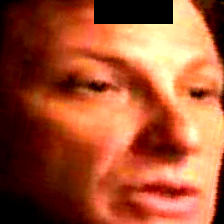

In [ ]:
face_datasets['train'][0][0]

#### DO NOT RUN: Finetuning InceptionResnetV1 with augmented data
Note: You don't need to run this cell. The best model will be loaded in the next section. 

The highest test accuracy for the trained model is 41.12%

In [ ]:
def run_epoch(model, optimizer, criterion, dataloader, sched=None, phases=['train', 'test']):
    model.to(device)
    accs = {phase: 0 for phase in phases}
    losses = {phase: 0 for phase in phases}
    for phase in phases:
        if phase == 'train':
          model.train()
        else:
          model.eval()
          
        pbar = tqdm(dataloader[phase], leave=phase=='test')
        n_data, correct_all, loss_all = 0, 0, 0

        for X, y in pbar:
            n_data += X.shape[0]
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if sched:
                  sched.step()

            pred = pred.argmax(axis=1)
            correct_all += (pred == y).sum().item()
            loss_all += loss.item()

            accs[phase] = correct_all / n_data
            losses[phase] = loss_all / n_data
            desc_str = ''
            for ph in phases: 
                desc_str += ' ' * 5 + f'{ph} loss: {losses[ph]:.6f}   {ph} accuracy: {accs[ph]:.4f}' 
            pbar.set_description(f'Epoch {epoch:3.0f}: {desc_str}')
    return accs, losses

def plot_history(losses, accs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    legend = list()
    for phase in losses.keys():
      plt.plot(range(1, len(losses[phase]) + 1), losses[phase])
      legend.append(f'{phase} loss')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')

    plt.subplot(2, 1, 2)
    legend = list()
    for phase in accs.keys():
      plt.plot(range(1, len(accs[phase]) + 1), accs[phase])
      legend.append(f'{phase} accuracy')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
inception_resnet2 = InceptionResnetV1(pretrained='vggface2', classify=True)

params = inception_resnet2.parameters()
for param in params: 
  param.requires_grad = False

inception_resnet2.logits = nn.Linear(in_features=512, out_features=3, bias=True)
inception_resnet2 = inception_resnet2.to(device)
resnet_accs, resnet_losses = defaultdict(list), defaultdict(list)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
shutil.copytree(facedataset_resized_root, 'Face Dataset - resized')

In [ ]:
batch_size = 64

transform_train = transforms.Compose([
    lambda img: augment_image(img) if random.choice([0, 1, 1]) == 1 else img, 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    fixed_image_standardization
])
transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    fixed_image_standardization
])

dataset_transforms = {'train':transform_train, 'test': transform_test}
face_datasets = {phase: ImageFolder(root=os.path.join('Face Dataset - resized', phase), transform=dataset_transforms[phase]) for phase in ['train', 'test']}
face_dataloaders = {phase: DataLoader(face_datasets[phase], batch_size=batch_size, num_workers=2, shuffle=True) for phase in ['train', 'test']}

Epoch   1:      train loss: 0.018383   train accuracy: 0.3334     test loss: 0.017594   test accuracy: 0.3295: 100%|██████████| 122/122 [00:23<00:00,  5.14it/s]
Epoch   2:      train loss: 0.017372   train accuracy: 0.3387     test loss: 0.017255   test accuracy: 0.3630: 100%|██████████| 122/122 [00:23<00:00,  5.17it/s]
Epoch   3:      train loss: 0.017164   train accuracy: 0.3564     test loss: 0.017297   test accuracy: 0.3406: 100%|██████████| 122/122 [00:23<00:00,  5.12it/s]
Epoch   4:      train loss: 0.017131   train accuracy: 0.3614     test loss: 0.017238   test accuracy: 0.3642: 100%|██████████| 122/122 [00:24<00:00,  4.91it/s]
Epoch   5:      train loss: 0.017116   train accuracy: 0.3691     test loss: 0.017282   test accuracy: 0.3591: 100%|██████████| 122/122 [00:23<00:00,  5.10it/s]


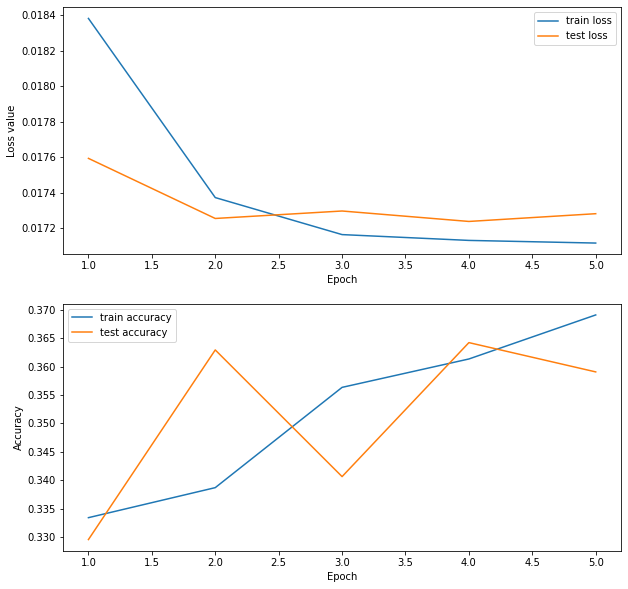

In [ ]:
max_lr = 0.0001
weight_decay = 1e-4
n_epochs = 5

fc_params = inception_resnet2.logits.parameters()
optimizer = optim.Adam(fc_params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, 
                                      steps_per_epoch=len(face_dataloaders['train']))
criterion = nn.CrossEntropyLoss()

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(resnet_accs['train']) + 1
  accs, losses = run_epoch(inception_resnet2, optimizer, criterion, face_dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    resnet_accs[phase].append(accs[phase])
    resnet_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(resnet_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(resnet_losses, f)

  if resnet_accs['test'][-1] == max(resnet_accs['test']): 
    best_inception_resnet2 = deepcopy(inception_resnet2)
    
torch.save(inception_resnet2.logits, os.path.join(resnet_fc_training_root, f"InceptionResnetV1_2_fc_epoch{len(resnet_accs['test'])}.pt"))
torch.save(best_inception_resnet2.logits, os.path.join(resnet_fc_training_root, 
                                               f"best_InceptionResnetV1_2_fc_epoch{1 + np.argmax(resnet_accs['test'])}_acc{max(resnet_accs['test'])}.pt"))
plot_history(resnet_losses, resnet_accs)

In [ ]:
params = inception_resnet2.parameters()
for param in params: 
  param.requires_grad = True
  
max_lr = 0.00005
params = inception_resnet2.parameters()
optimizer = optim.SGD(params, lr=max_lr, momentum=0.9) # optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = None # optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, steps_per_epoch=len(face_dataloaders['train']))
criterion = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 10

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(resnet_accs['train']) + 1
  accs, losses = run_epoch(inception_resnet2, optimizer, criterion, face_dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    resnet_accs[phase].append(accs[phase])
    resnet_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(resnet_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(resnet_losses, f)

  if resnet_accs['test'][-1] == max(resnet_accs['test']): 
    best_inception_resnet2 = deepcopy(inception_resnet2)
    
torch.save(inception_resnet2, os.path.join(resnet_fc_training_root, f"InceptionResnetV1_2_epoch{len(resnet_accs['test'])}.pt"))
torch.save(best_inception_resnet2, os.path.join(resnet_fc_training_root, 
                                               f"best_InceptionResnetV1_2_epoch{1 + np.argmax(resnet_accs['test'])}_acc{max(resnet_accs['test']):.4f}.pt"))
plot_history(resnet_losses, resnet_accs)
print(f"\nHighest test accuracy is {100 * max(resnet_accs['test']):.2f}%")

Epoch   6:      train loss: 0.017125   train accuracy: 0.3650     test loss: 0.017665   test accuracy: 0.2737: 100%|██████████| 122/122 [00:23<00:00,  5.12it/s]
Epoch   7:      train loss: 0.017117   train accuracy: 0.3639     test loss: 0.017469   test accuracy: 0.2783: 100%|██████████| 122/122 [00:24<00:00,  5.03it/s]
Epoch   8:      train loss: 0.017091   train accuracy: 0.3710     test loss: 0.017383   test accuracy: 0.3137: 100%|██████████| 122/122 [00:25<00:00,  4.86it/s]
Epoch   9:      train loss: 0.017070   train accuracy: 0.3708     test loss: 0.000000   test accuracy: 0.0000:  17%|█▋        | 85/488 [01:49<07:32,  1.12s/it]

# Part 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights
import torchvision
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as T
from torchvision.transforms import Compose
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from IPython import display
from tqdm import tqdm
import pickle
import numpy as np
from collections import defaultdict
from copy import deepcopy

train_dirs = {'image':'/content/train_ende', 'sentence':'/content/english_train.txt', \
              'dialogue':'/content/image_index_train.txt', 'sentiment':'/content/sentiment_train.txt'}
test_dirs = {'image':'/content/test', 'sentence':'/content/english_test.txt', \
              'dialogue':'/content/image_index_test.txt', 'sentiment':'/content/sentiment_test.txt'}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


## Image classification: Pretrained CNN model

In [ ]:
imagedataset_root = os.path.join(project_root, 'Resized Image Dataset')
imagedataset_labels_root = {(phase, s): os.path.join(imagedataset_root, phase, str(s)) for s in range(3) for phase in ['test', 'train']}
for root in imagedataset_labels_root.values(): os.makedirs(root, exist_ok=True)

In [ ]:
data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

weight_transform = ResNet50_Weights.IMAGENET1K_V2.transforms()

In [ ]:
datasets = dict()
datasets['train'] = MSCTDataset(train_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False, image_transform=data_transform)
datasets['test'] = MSCTDataset(test_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False, image_transform=data_transform)

In [ ]:
img, s = datasets['train'][100]
img.shape

torch.Size([3, 256, 256])

## Train 

In [ ]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=64,
                                shuffle=True),
    'test':
    torch.utils.data.DataLoader(datasets['test'],
                                batch_size=64,
                                shuffle=False)
}

In [ ]:
def run_epoch(model, optimizer, criterion, dataloader, sched=None, phases=['train', 'test']):
    model.to(device)
    accs = {phase: 0 for phase in phases}
    losses = {phase: 0 for phase in phases}
    for phase in phases:
        if phase == 'train':
          model.train()
        else:
          model.eval()
          
        pbar = tqdm(dataloader[phase], leave=phase=='test')
        n_data, correct_all, loss_all = 0, 0, 0

        for X, y in pbar:
            n_data += X.shape[0]
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if sched:
                  sched.step()

            pred = pred.argmax(axis=1)
            correct_all += (pred == y).sum().item()
            loss_all += loss.item()

            accs[phase] = correct_all / n_data
            losses[phase] = loss_all / n_data
            desc_str = ''
            for ph in phases: 
                desc_str += f'{ph} loss: {losses[ph]:.6f}, {ph} accuracy: {100*accs[ph]:.3f}%' 
            pbar.set_description(f'Epoch {epoch:2.0f}: {desc_str}')
    return accs, losses

def plot_history(losses, accs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    legend = list()
    for phase in losses.keys():
      plt.plot(range(1, len(losses[phase]) + 1), losses[phase])
      legend.append(f'{phase} loss')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')

    plt.subplot(2, 1, 2)
    legend = list()
    for phase in accs.keys():
      plt.plot(range(1, len(accs[phase]) + 1), accs[phase])
      legend.append(f'{phase} accuracy')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
max_lr = 0.0004
weight_decay = 1e-3
n_epochs = 10

In [ ]:
# resnet_fc_training_root = os.path.join(project_root, 'training checkpoints', 'InceptionResnetV1 finetuning fc')
# os.makedirs(resnet_fc_training_root, exist_ok=True)

model = resnet50(weights="IMAGENET1K_V2")
model = model.to(device)

# model = model.cuda() if use_cuda else model
for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)

resnet_accs, resnet_losses = defaultdict(list), defaultdict(list)
optimizer = optim.Adam(model.fc.parameters(), max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, 
                                      steps_per_epoch=len(dataloaders['train']))
criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch  1: train loss: 0.017099, train accuracy: 37.208%test loss: 0.017291, test accuracy: 39.668%: 100%|██████████| 80/80 [01:32<00:00,  1.16s/it]
Epoch  2: train loss: 0.016958, train accuracy: 39.748%test loss: 0.017317, test accuracy: 40.695%: 100%|██████████| 80/80 [01:28<00:00,  1.10s/it]
Epoch  3: train loss: 0.016804, train accuracy: 41.250%test loss: 0.017518, test accuracy: 34.715%: 100%|██████████| 80/80 [01:28<00:00,  1.10s/it]
Epoch  4: train loss: 0.016648, train accuracy: 43.216%test loss: 0.017294, test accuracy: 40.497%: 100%|██████████| 80/80 [01:28<00:00,  1.11s/it]
Epoch  5: train loss: 0.016487, train accuracy: 44.773%test loss: 0.017234, test accuracy: 41.109%: 100%|██████████| 80/80 [01:28<00:00,  1.11s/it]
Epoch  6: train loss: 0.016385, train accuracy: 45.494%test loss: 0.017446, test accuracy: 38.366%: 100%|██████████| 80/80 [01:28<00:00,  1.11s/it]
Epoch  7: train loss: 0.016300, train accuracy: 46.245%test loss: 0.017428, test accuracy: 37.813%: 100%|███████

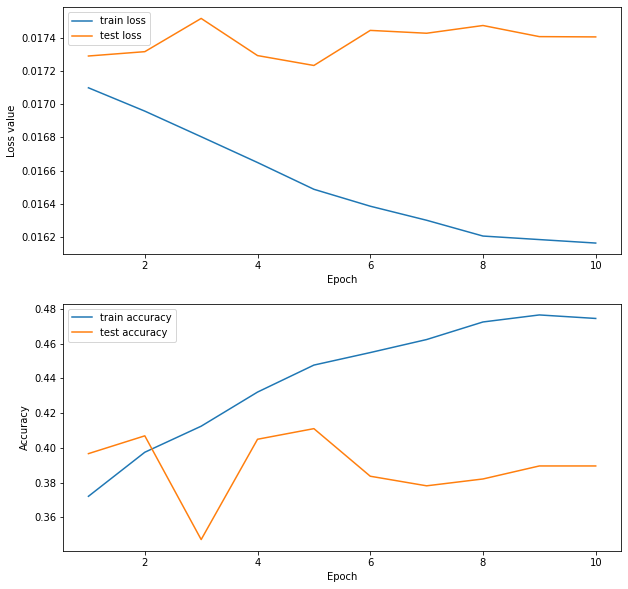

In [ ]:
phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(resnet_accs['train']) + 1
  accs, losses = run_epoch(model, optimizer, criterion, dataloaders, 
                        sched=sched, phases=phases)
  for phase in phases:
    resnet_accs[phase].append(accs[phase])
    resnet_losses[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(resnet_accs, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(resnet_losses, f)

  if resnet_accs['test'][-1] == max(resnet_accs['test']): 
    best_inception_resnet = deepcopy(model)
    
# torch.save(model.logits, os.path.join(resnet_fc_training_root, f"InceptionResnetV1_fc_epoch{len(resnet_accs['test'])}.pt"))
# torch.save(best_inception_resnet.logits, os.path.join(resnet_fc_training_root, 
                                              #  f"best_InceptionResnetV1_fc_epoch{1 + np.argmax(resnet_accs['test'])}_acc{max(resnet_accs['test'])}.pt"))
plot_history(resnet_losses, resnet_accs)

In [ ]:
PATH = project_root + "/models"
torch.save(model, PATH)

# Part 3

In [ ]:
face_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        # transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        fixed_image_standardization
    ])

scene_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

from statistics import mode
import random

class SceneClassifier2(nn.Module):
  def __init__(self, face_classifier, resnet_scene, face_transform=face_transform):
    super().__init__()
    mtcnn = MTCNN(keep_all=True, device=device)
    self.mtcnn_wrapped = MTCNNWrapper(mtcnn, include_boxes=True, include_scores=True,\
                                      face_transform=face_transform)
    self.face_classifier = face_classifier.to(device)
    self.resnet_scene = resnet_scene.to(device)
    
  def forward(self, scene):
    self.resnet_scene.eval()
    self.face_classifier.eval()

    scene_pred = self.resnet_scene(scene_transform(scene).unsqueeze(0).to(device))
    faces, boxes, scores = self.mtcnn_wrapped(scene)
    if len(faces) == 0:
      #train_dist = torch.tensor([6922, 7835, 5483])
      #return (train_dist / train_dist.sum()).to(device)
      return scene_pred.argmax().item()
    # preds = list()
    preds = torch.zeros((3,))
    for face, box, score in zip(faces, boxes, scores):
      box = torch.tensor(box.ravel())
      score = torch.tensor(score)
      frame_dims = torch.tensor(scene.size)
      face = face.to(device).unsqueeze(0)
      face_predictions = self.face_classifier(face)
      p = F.softmax(face_predictions, 1).cpu()
      logp = torch.log2(p)
      entropy = torch.sum(-p * logp).item()
      pred = face_predictions.argmax().item()
      # preds[pred] += (1 / entropy)
      preds += p.reshape(-1) / entropy

    # preds = preds / len(face)
    scene_pred = F.softmax(scene_pred, 1).cpu()
    scene_pred = scene_pred / torch.sum(-scene_pred * torch.log2(scene_pred)).item()

    # print(scene_pred, preds)
    final_pred = preds + scene_pred
    # print(final_pred)

    return final_pred.argmax().item()


In [ ]:
PATH2 = project_root + "/models"
resnet_scene = torch.load(PATH2)
face_classifier = torch.load(os.path.join(resnet_fc_training_root, f"best_InceptionResnetV1_epoch{8}_acc{0.4112}.pt"))
scene_classifier = SceneClassifier2(face_classifier, resnet_scene)

sentiment: 1, predicted: 1
So let's act like it.


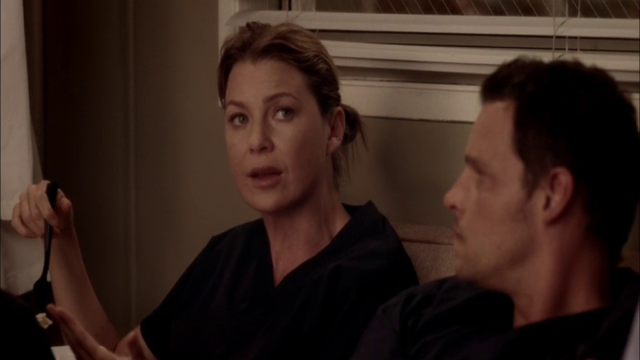

In [ ]:
frame, sentence, dialogue, sentiment = train_data[100]
pred = scene_classifier(frame)

print(f'sentiment: {sentiment}, predicted: {pred}\n{sentence}')
display.display(frame.resize((640, 360), Image.BILINEAR), display_id=False)

In [ ]:
dataset = MSCTDataset(test_dirs, pack_dialogues=False, include_dialogues=False, include_sentences=False)

corrects = list()
pbar = tqdm(dataset)
for frame, sentiment in pbar:
  pred = scene_classifier(frame)
  
  corrects.append(1. * (sentiment == pred))
  # print(pred)
  pbar.set_description(f'accuracy: {np.mean(corrects) * 100 :.2f}%')
  if len(corrects) == len(dataset): 
    break

print(f'Final accuracy: {np.mean(corrects) * 100 :.2f}%')

accuracy: 42.69%: 100%|█████████▉| 5066/5067 [13:33<00:00,  6.23it/s]

Final accuracy: 42.69%
